<a href="https://colab.research.google.com/github/Prashanthwizzie/ML_projects/blob/main/ICICI_Bank_Stock_Data_Analysis_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
!pip install pmdarima

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [19]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [20]:
from datetime import datetime

In [21]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')

In [23]:
stock_data = pd.read_csv("/content/ICICIBANK.NS.csv",sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [24]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-05-02,227.272720,229.854538,226.736359,227.709091,204.749756,9145994.0
2014-05-05,226.590912,232.181824,225.090912,227.718185,204.757950,14052241.0
2014-05-06,229.854538,232.727264,229.854538,231.927277,208.542603,7045379.0
2014-05-07,232.000000,232.181824,228.490906,231.027267,207.733383,28329075.0
2014-05-08,231.800003,235.781815,230.227264,234.363632,210.733337,16439945.0
...,...,...,...,...,...,...
2022-12-12,925.049988,933.900024,925.049988,930.299988,930.299988,8493863.0
2022-12-13,929.500000,935.900024,927.799988,932.950012,932.950012,10415140.0
2022-12-14,936.000000,936.049988,920.000000,921.750000,921.750000,12319827.0


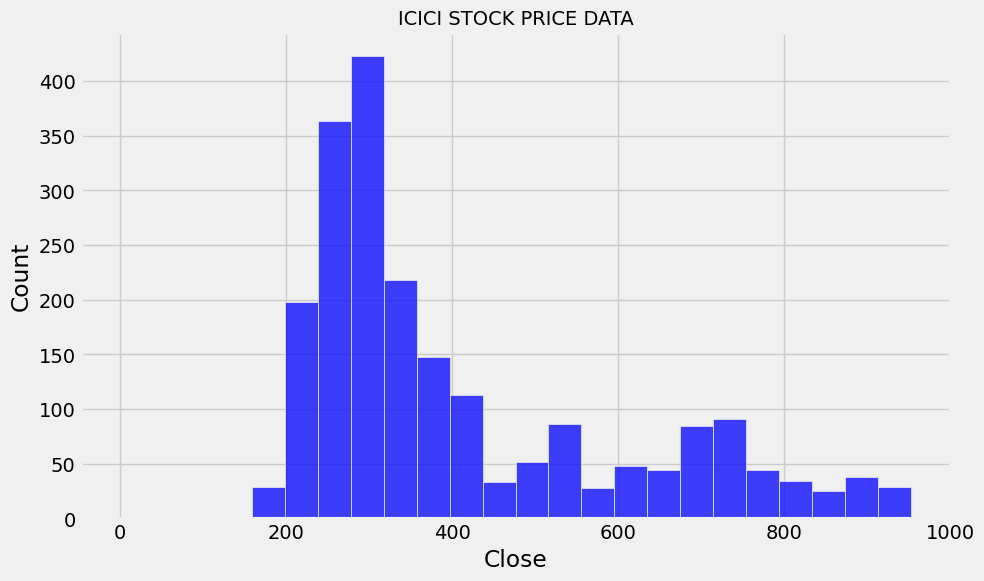

In [25]:
sns.histplot(data=stock_data, x="Close",color="b")
plt.title("ICICI STOCK PRICE DATA",fontsize=14)
plt.show()

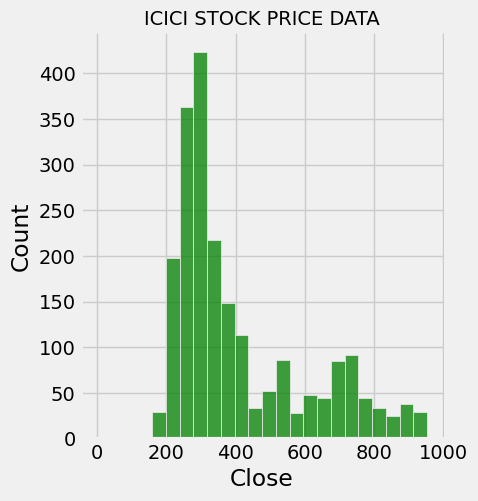

In [26]:
sns.displot(data=stock_data, x="Close",color="g")
plt.title("ICICI STOCK PRICE DATA",fontsize=14)
plt.show()

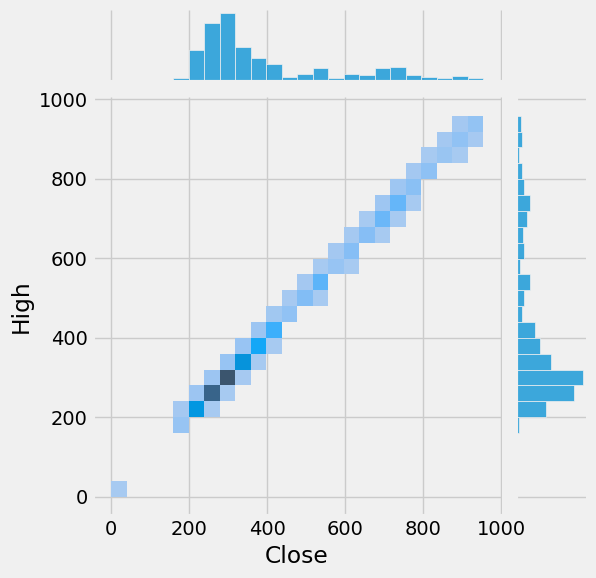

In [27]:
sns.jointplot(data=stock_data, x="Close", y="High", kind="hist")
plt.show()


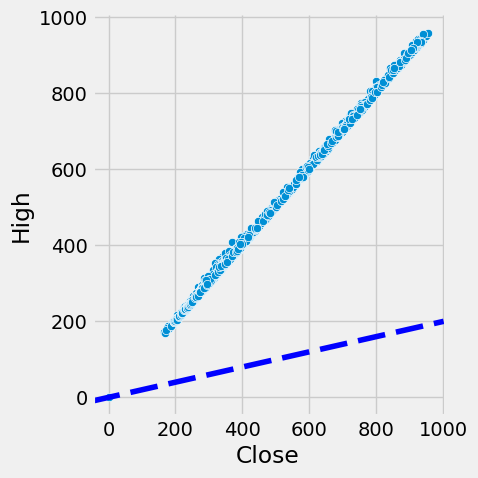

In [28]:
tips = sns.load_dataset("tips")
g = sns.relplot(data=stock_data, x="Close", y="High")
g.ax.axline(xy1=(10, 2), slope=.2, color="b", dashes=(5, 2))
plt.show()

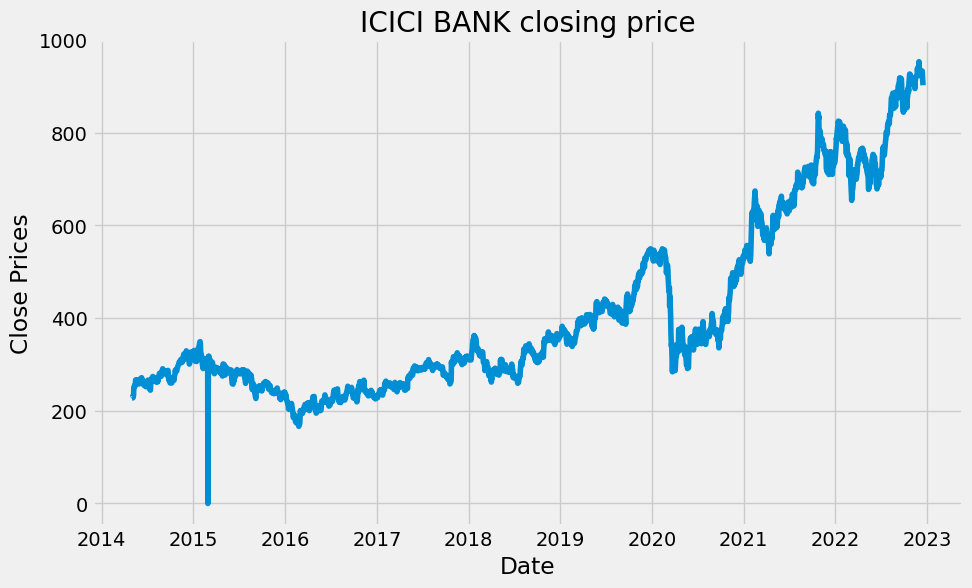

In [29]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ICICI BANK closing price')
plt.show()

<Axes: ylabel='Density'>

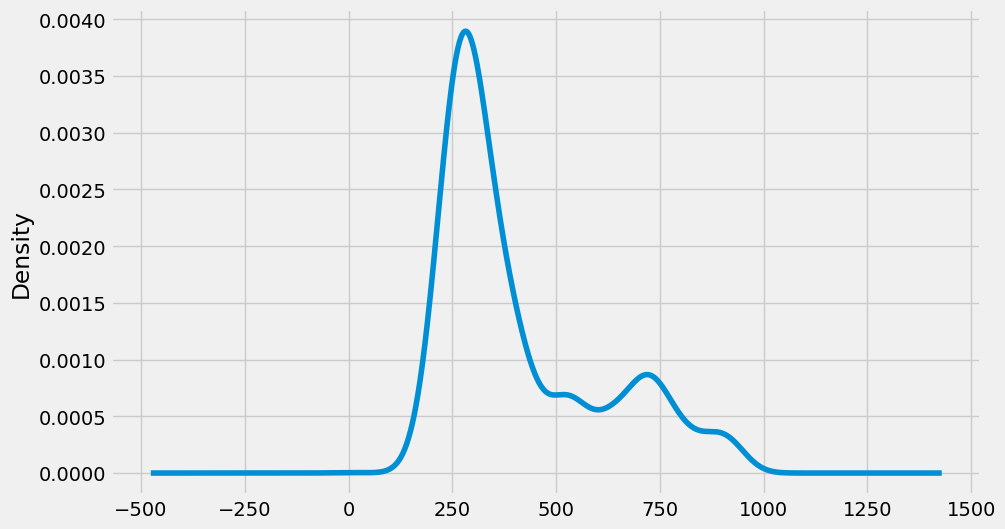

In [30]:
#Distribution of the dataset
stock_data.Close.plot(kind='kde')

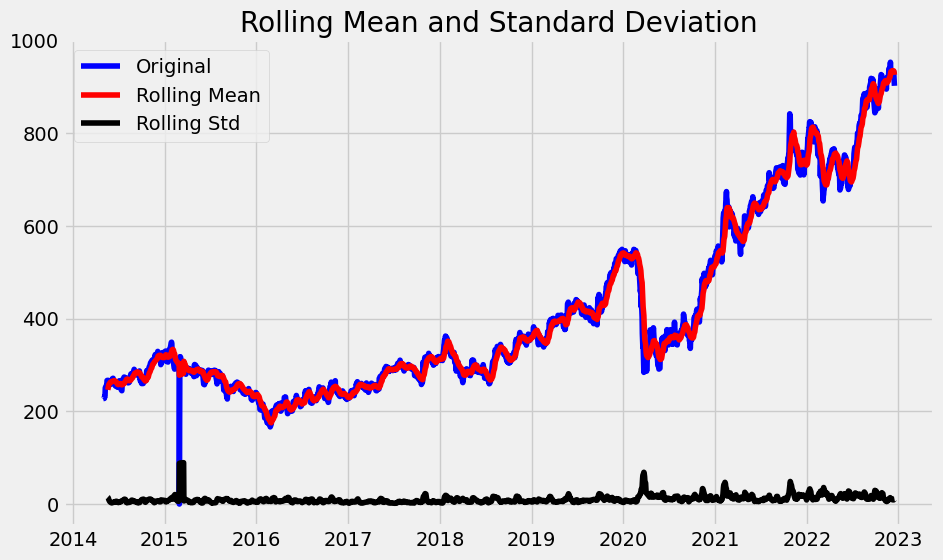

Results of dickey fuller test
Test Statistics                   0.400216
p-value                           0.981503
No. of lags used                  5.000000
Number of observations used    2124.000000
critical value (1%)              -3.433432
critical value (5%)              -2.862902
critical value (10%)             -2.567495
dtype: float64


In [31]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(stock_data.Close)

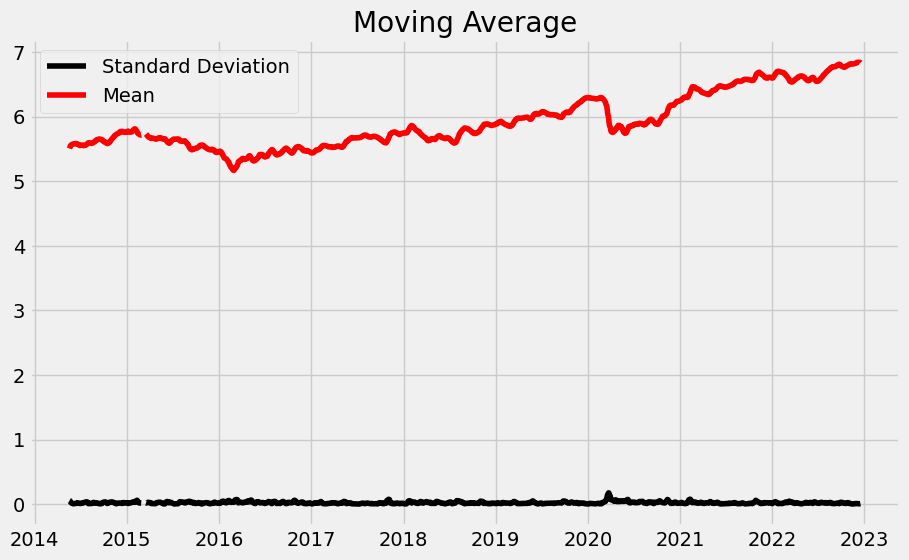

In [32]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(stock_data.Close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

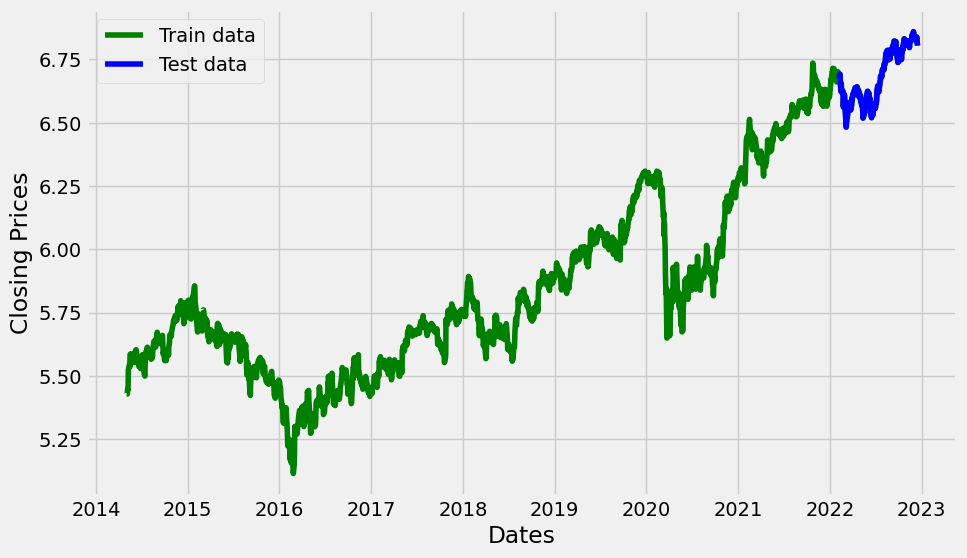

In [33]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()